Imports

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import matplotlib.pyplot as plt
import config as cfg

Constants

In [3]:
# Define paths and constants
dataset_directory = cfg.DATASET_PATH
labels_path = cfg.LABEL_PATH
batch_size = 32
epochs = 10
IMG_SIZE = (160, 160)
CLASSES = ['cooling', 'pollen', 'varroa', 'wasps', 'bee']
mlb = MultiLabelBinarizer()


Unprocessed data

In [9]:
# Load labels from JSON
import json

with open(labels_path) as json_file:
    labels = json.load(json_file)

# Create a list of image paths and corresponding labels
image_paths = []
image_labels = []

for image_name, label in labels.items():
    image_path = os.path.join(dataset_directory, image_name)
    image_paths.append(image_path)
    image_labels.append(label)


# Processed data

In [10]:
labels = []
for label_dict in image_labels:
    label = [lbl for lbl, has in label_dict.items() if has]
    if 'wasps' not in label:
        label.append('bee')
    labels.append(label)

train_data = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

In [11]:
train_data.shape

(7490, 2)

Split test dataset

In [12]:
test_data = train_data.sample(frac=0.02)
train_data = train_data.drop(test_data.index)

In [13]:
print(train_data.shape)
print(test_data.shape)

(7340, 2)
(150, 2)


Data generation

In [14]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2
)

In [15]:
# Data augmentation with generator
train_generator = datagen.flow_from_dataframe(
    train_data,
    x_col='image_paths',
    y_col='labels',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)
valid_gen = datagen.flow_from_dataframe(
    train_data,
    x_col='image_paths',
    y_col='labels',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)


Found 5872 validated image filenames belonging to 5 classes.
Found 1468 validated image filenames belonging to 5 classes.


# Model

In [17]:
# Load MobileNet model with pre-trained weights and exclude the top layer
base_model = tf.keras.applications.MobileNet(
    input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet'
)

base_model.trainable = False

# Add custom classification layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='sigmoid'),
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_160 (Functi  (None, 5, 5, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 3233989 (12.34 MB)
Trainable params: 5125 (20.02 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [82]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_gen,
    epochs=epochs
)


Epoch 1/10
184/184 [==============================] - 63s 335ms/step - loss: 0.5121 - accuracy: 0.4300 - val_loss: 0.6144 - val_accuracy: 0.2486
Epoch 2/10
184/184 [==============================] - 60s 326ms/step - loss: 0.3493 - accuracy: 0.4901 - val_loss: 0.4776 - val_accuracy: 0.2527
Epoch 3/10
184/184 [==============================] - 61s 332ms/step - loss: 0.2863 - accuracy: 0.5031 - val_loss: 0.3987 - val_accuracy: 0.2875
Epoch 4/10
184/184 [==============================] - 59s 322ms/step - loss: 0.2393 - accuracy: 0.5303 - val_loss: 0.3211 - val_accuracy: 0.4046
Epoch 5/10
184/184 [==============================] - 60s 325ms/step - loss: 0.2064 - accuracy: 0.5581 - val_loss: 0.2825 - val_accuracy: 0.4557
Epoch 6/10
184/184 [==============================] - 60s 324ms/step - loss: 0.1889 - accuracy: 0.5661 - val_loss: 0.2525 - val_accuracy: 0.5000
Epoch 7/10
184/184 [==============================] - 63s 342ms/step - loss: 0.1677 - accuracy: 0.5761 - val_loss: 0.2411 - val_ac

In [83]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

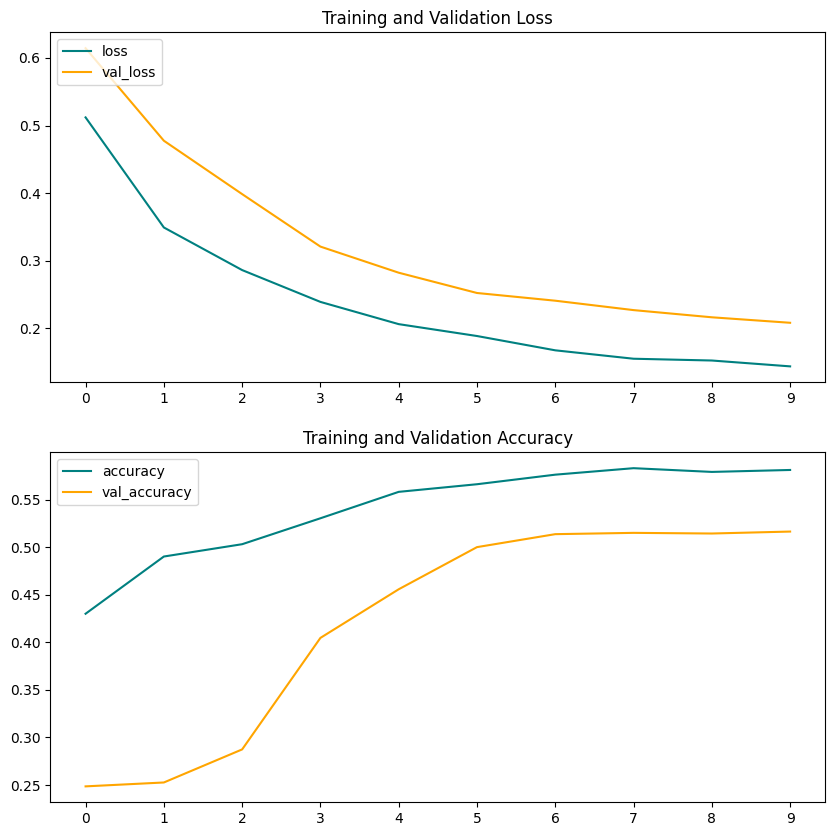

In [84]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss, color='orange', label='val_loss')
plt.xticks(range(history.epoch[-1] + 1))
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, color='teal', label='accuracy')
plt.plot(val_acc, color='orange', label='val_accuracy')
plt.xticks(range(history.epoch[-1] + 1))
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
model.save(cfg.MODEL_SAVE_PATH)

# Testing

In [85]:
# Evaluate the model on the test dataset
test_generator = datagen.flow_from_dataframe(
    test_data,
    x_col='image_paths',
    y_col='labels',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

predictions = model.predict(test_generator)


Found 150 validated image filenames belonging to 5 classes.
5/5 [==============================] - 2s 290ms/step


In [86]:
predicted_classes = (predictions >= 0.5).astype(int)
true_classes = mlb.fit_transform(test_generator.classes)

Confusion Matrix

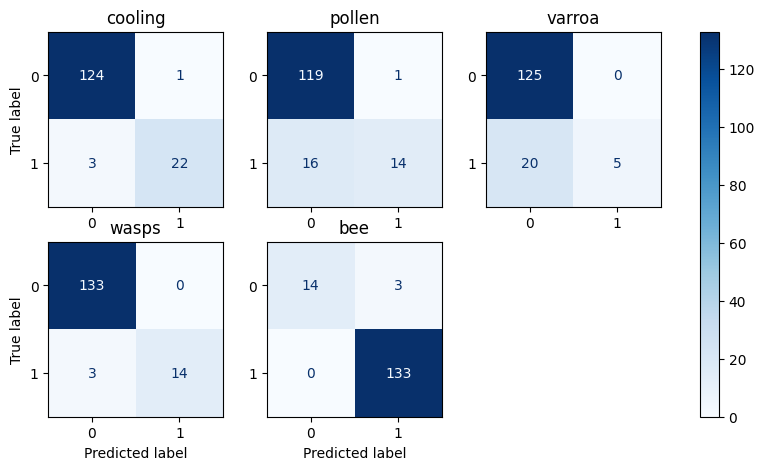

In [87]:
# Calculate and display metrics
cm = multilabel_confusion_matrix(true_classes, predicted_classes)

fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()

for i in range(5):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axs[i], cmap=plt.cm.Blues)
    disp.ax_.set_title(CLASSES[i])

    if i < 3:
        disp.ax_.set_xlabel('')
    if i % 3 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

fig.delaxes(axs[-1])
fig.colorbar(disp.im_, ax=axs)

plt.show()